<a href="https://colab.research.google.com/github/vd4mmind/googleColab/blob/ML_scRNASeq_SK_lab_2020/Day3_01_Advanced_Clustering_Embryoid_Body_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install phate scprep umap-learn tasklogger magic-impute louvain seaborn
!pip install git+https://github.com/jacoblevine/phenograph.git

     |████████████████████████████████| 102kB 3.1MB/s 
     |████████████████████████████████| 2.2MB 9.0MB/s 
     |████████████████████████████████| 419kB 19.8MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 3.2MB 21.8MB/s 
     |████████████████████████████████| 1.8MB 41.4MB/s 
  Cloning https://github.com/jacoblevine/phenograph.git to /tmp/pip-req-build-b_5s6s1c
  Running command git clone -q https://github.com/jacoblevine/phenograph.git /tmp/pip-req-build-b_5s6s1c
  Created wheel for PhenoGraph: filename=PhenoGraph-1.5.2-cp36-none-any.whl size=151658 sha256=056c714ba101380b862c2661320c120b2db8aa949423f8a71d772d6fc02896ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-8g7pn197/wheels/78/4e/51/59f41302009330e31c4a2d0dc1cbbdad17f4379471d40ab9af
Successfully built PhenoGraph


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import magic
import phenograph
import louvain

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.


<a id='loading'></a>
# 1. Loading preprocessed data

### Load EB Data

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have sample labels. Replace all references to `metadata['sample_labels']` with an entry from `metadata`, or your favorite gene.

In [0]:
scprep.io.download.download_google_drive(id='14ahKKvzjlSa5w6YUDUthNESHGU8naPdw',
                                         destination='data.pickle.gz')
scprep.io.download.download_google_drive(id='1-XvGMHn_fluRlxcyoScVCSQphrvABSsj',
                                         destination='metadata.pickle.gz')
data = pd.read_pickle('data.pickle.gz')
metadata = pd.read_pickle('metadata.pickle.gz')

# 2. Denoising using MAGIC

As we mentioned, because scRNA-seq, suffers from dropout (the undercounting of mRNA molecules in single cells), examining expression of lowly expressed genes can be challenging. To overcome this, we developed a method for denoising called MAGIC (Markov Affinity Graph Imputation in Cells; [PMID: 29961576 ](https://www.ncbi.nlm.nih.gov/pubmed/29961576)). 

Without going into too much technical detail about how it works, the basic idea is that although gene expression counts in each cell are unreliable, the gene expression counts matrix contains several degrees of redundancy between genes (i.e. expression of genes is not completely indepdent) and among cells (i.e. we see very similar cells more than once).

A full description of MAGIC can be found in the paper, and on our website: [Denoising and imputing scRNA-seq data](https://www.krishnaswamylab.org/blog/2018/10/28/denoising-noisy-gene-expression-in-scrna-seq).

#### Running MAGIC

Because MAGIC returns a dense matrix (many zeros in the counts matrix are removed), we only want to keep expression of a few marker genes. The list in the following cell is a set of biologically relevant genes for this dataset, and we will use some of these later. If you'd like to use other genes in the rest of the notebook, feel free to add them to this list!

In [4]:
marker_genes = scprep.select.get_gene_set(data, exact_word=[
    'ARID3A', 'ASCL2',  'CD34', 'CDX2', 'CER1', 'DLX1',
    'DMRT3', 'EN2', 'EOMES', 'FOXA2', 'FOXD3-AS1', 'GATA3-AS1',
    'GATA4', 'GATA5', 'GATA6-AS1', 'GBX2', 'GLI3', 'HOXA2',
    'HOXB1', 'HOXB4', 'HOXD13', 'HOXD9', 'ISL1', 'KLF5',
    'KLF7', 'LEF1', 'LHX2', 'LHX5', 'LMX1A', 'MAP2',
    'MIXL1', 'MYCBP', 'NANOG', 'NES', 'NKX2-1', 'NKX2-5',
    'NKX2-8', 'NPAS1', 'NR2F1-AS1', 'OLIG1', 'OLIG3', 'ONECUT1',
    'ONECUT2', 'OTX2', 'PAX3', 'PAX6', 'PDGFRA', 'PECAM1',
    'POU5F1', 'SATB1', 'SIX2', 'SIX3-AS1', 'SIX6', 'SOX13',
    'SOX10', 'SOX15', 'SOX17', 'SOX9', 'TTLL10', 'TAL1',
    'TBX15', 'TBX18', 'TBX5', 'TNNT2', 'WT1', 'ZBTB16',
    'ZIC2', 'ZIC5', 'ACTB', 'HAND1'])
marker_genes

array(['ACTB (ENSG00000075624)', 'ARID3A (ENSG00000116017)',
       'ASCL2 (ENSG00000183734)', 'CD34 (ENSG00000174059)',
       'CDX2 (ENSG00000165556)', 'CER1 (ENSG00000147869)',
       'DLX1 (ENSG00000144355)', 'DMRT3 (ENSG00000064218)',
       'EN2 (ENSG00000164778)', 'EOMES (ENSG00000163508)',
       'FOXA2 (ENSG00000125798)', 'FOXD3-AS1 (ENSG00000230798)',
       'GATA3-AS1 (ENSG00000197308)', 'GATA4 (ENSG00000136574)',
       'GATA5 (ENSG00000130700)', 'GATA6-AS1 (ENSG00000266010)',
       'GBX2 (ENSG00000168505)', 'GLI3 (ENSG00000106571)',
       'HAND1 (ENSG00000113196)', 'HOXA2 (ENSG00000105996)',
       'HOXB1 (ENSG00000120094)', 'HOXB4 (ENSG00000182742)',
       'HOXD13 (ENSG00000128714)', 'HOXD9 (ENSG00000128709)',
       'ISL1 (ENSG00000016082)', 'KLF5 (ENSG00000102554)',
       'KLF7 (ENSG00000118263)', 'LEF1 (ENSG00000138795)',
       'LHX2 (ENSG00000106689)', 'LHX5 (ENSG00000089116)',
       'LMX1A (ENSG00000162761)', 'MAP2 (ENSG00000078018)',
       'MIXL1 (ENSG0000018

In [5]:
data_magic = magic.MAGIC().fit_transform(data, genes=marker_genes)

Calculating MAGIC...
  Running MAGIC on 9750 cells and 16507 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 21.29 seconds.
    Calculating KNN search...
    Calculated KNN search in 14.66 seconds.
    Calculating affinities...
    Calculated affinities in 14.55 seconds.
  Calculated graph and diffusion operator in 51.69 seconds.
  Calculating imputation...
  Calculated imputation in 0.05 seconds.
Calculated MAGIC in 55.52 seconds.


In [6]:
data_magic.head()

,ACTB (ENSG00000075624),ARID3A (ENSG00000116017),ASCL2 (ENSG00000183734),CD34 (ENSG00000174059),CDX2 (ENSG00000165556),CER1 (ENSG00000147869),DLX1 (ENSG00000144355),DMRT3 (ENSG00000064218),EN2 (ENSG00000164778),EOMES (ENSG00000163508),FOXA2 (ENSG00000125798),FOXD3-AS1 (ENSG00000230798),GATA3-AS1 (ENSG00000197308),GATA4 (ENSG00000136574),GATA5 (ENSG00000130700),GATA6-AS1 (ENSG00000266010),GBX2 (ENSG00000168505),GLI3 (ENSG00000106571),HAND1 (ENSG00000113196),HOXA2 (ENSG00000105996),HOXB1 (ENSG00000120094),HOXB4 (ENSG00000182742),HOXD13 (ENSG00000128714),HOXD9 (ENSG00000128709),ISL1 (ENSG00000016082),KLF5 (ENSG00000102554),KLF7 (ENSG00000118263),LEF1 (ENSG00000138795),LHX2 (ENSG00000106689),LHX5 (ENSG00000089116),LMX1A (ENSG00000162761),MAP2 (ENSG00000078018),MIXL1 (ENSG00000185155),MYCBP (ENSG00000214114),NANOG (ENSG00000111704),NES (ENSG00000132688),NKX2-1 (ENSG00000136352),NKX2-5 (ENSG00000183072),NKX2-8 (ENSG00000136327),NPAS1 (ENSG00000130751),NR2F1-AS1 (ENSG00000237187),OLIG1 (ENSG00000184221),OLIG3 (ENSG00000177468),ONECUT1 (ENSG00000169856),ONECUT2 (ENSG00000119547),OTX2 (ENSG00000165588),PAX3 (ENSG00000135903),PAX6 (ENSG00000007372),PDGFRA (ENSG00000134853),PECAM1 (ENSG00000261371),POU5F1 (ENSG00000204531),SATB1 (ENSG00000182568),SIX2 (ENSG00000170577),SIX3-AS1 (ENSG00000236502),SIX6 (ENSG00000184302),SOX10 (ENSG00000100146),SOX13 (ENSG00000143842),SOX15 (ENSG00000129194),SOX17 (ENSG00000164736),SOX9 (ENSG00000125398),TBX15 (ENSG00000092607),TBX18 (ENSG00000112837),TBX5 (ENSG00000089225),TNNT2 (ENSG00000118194),TTLL10 (ENSG00000162571),WT1 (ENSG00000184937),ZBTB16 (ENSG00000109906),ZIC2 (ENSG00000043355),ZIC5 (ENSG00000139800)
AAACATTGAAAGCA-1_Day 00-03,4.762814,0.133805,0.011452,0.0,0.073557,0.316344,0.000540,0.000568,0.000000,0.435771,0.144129,0.662554,0.016521,0.045847,0.000703,0.012639,0.031138,0.039951,0.052421,0.017675,0.018636,0.000074,0.0,0.000000,0.053406,0.011270,0.023413,0.189156,0.003436,0.075541,0.000000,0.047809,0.378245,0.302367,0.541805,0.191533,0.0,0.025901,0.000000,0.074747,0.009137,0.00000,0.016939,0.001956,0.002785,0.356523,0.019635,0.002250,0.010456,0.000099,2.816601,0.051878,0.000000,0.004719,0.000806,0.000000,0.074680,0.062000,0.076708,0.022531,0.0,0.0,0.000000,0.010694,0.000069,0.006155,0.002540,0.129776,0.022266
AAACCGTGCAGAAA-1_Day 00-03,5.225116,0.195429,0.005719,0.0,0.009512,0.002767,0.000766,0.020889,0.002016,0.001063,0.002269,0.097279,0.005089,0.000068,0.000558,0.000717,0.056054,0.355213,0.005567,0.002578,0.004058,0.001158,0.0,0.000077,0.003716,0.002923,0.025767,0.238065,0.328228,0.694916,0.025861,0.188427,0.001250,0.232982,0.009541,0.281872,0.0,0.001284,0.000817,0.061053,0.019154,0.00022,0.001454,0.000000,0.002611,0.455358,0.155933,0.587304,0.000251,0.000345,0.290068,0.042778,0.000058,0.046678,0.110101,0.005330,0.023681,0.073427,0.000346,0.065365,0.0,0.0,0.000026,0.008012,0.000511,0.000000,0.136504,0.103338,0.026035
AAACGCACCGGTAT-1_Day 00-03,5.473935,0.211985,0.016353,0.0,0.012489,0.000209,0.000000,0.000000,0.000000,0.002304,0.000022,1.275494,0.000270,0.000055,0.000000,0.000000,0.000306,0.060843,0.001629,0.000000,0.000000,0.000000,0.0,0.000000,0.007377,0.001747,0.017047,0.016951,0.000000,0.079216,0.000000,0.043802,0.002176,0.255698,0.201547,0.167596,0.0,0.000000,0.000000,0.094167,0.020943,0.00000,0.003945,0.020492,0.010057,0.662319,0.000000,0.001423,0.014510,0.000000,2.886547,0.034724,0.000000,0.000287,0.000574,0.002876,0.136835,0.121375,0.000028,0.010796,0.0,0.0,0.000000,0.056378,0.000656,0.000000,0.000000,0.120584,0.051942
AAAGATCTGGTACT-1_Day 00-03,5.674530,0.205984,0.015498,0.0,0.010047,0.000669,0.000000,0.000000,0.000000,0.003709,0.000155,1.105788,0.000553,0.000015,0.000000,0.000000,0.000325,0.037353,0.002462,0.000073,0.000016,0.000000,0.0,0.000000,0.002896,0.004793,0.016639,0.007429,0.000046,0.079662,0.000000,0.030473,0.003241,0.257504,0.162152,0.159027,0.0,0.000014,0.000000,0.094928,0.023860,0.00000,0.009142,0.002620,0.004646,0.746218,0.000025,0.001624,0.005599,0.000038,2.882000,0.0

In [7]:
data_magic.shape

(9750, 69)

# 3. Visualizing the data

We've already spent time discussing visualizations of this data using tSNE, PHATE, and UMAP. Here, we're going to focus on PHATE, but feel free to try running another algorithm here.

In [8]:
data_phate = phate.PHATE().fit_transform(data)
# alternative: umap.UMAP(), sklearn.manifold.TSNE()
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 9750 observations and 16507 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 20.90 seconds.
    Calculating KNN search...
    Calculated KNN search in 14.66 seconds.
    Calculating affinities...
    Calculated affinities in 0.89 seconds.
  Calculated graph and diffusion operator in 37.00 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.44 seconds.
    Calculating KMeans...
    Calculated KMeans in 30.65 seconds.
  Calculated landmark operator in 33.47 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 4.54 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.73 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.79 seconds.
Calculated PHATE in 85.56 seconds.


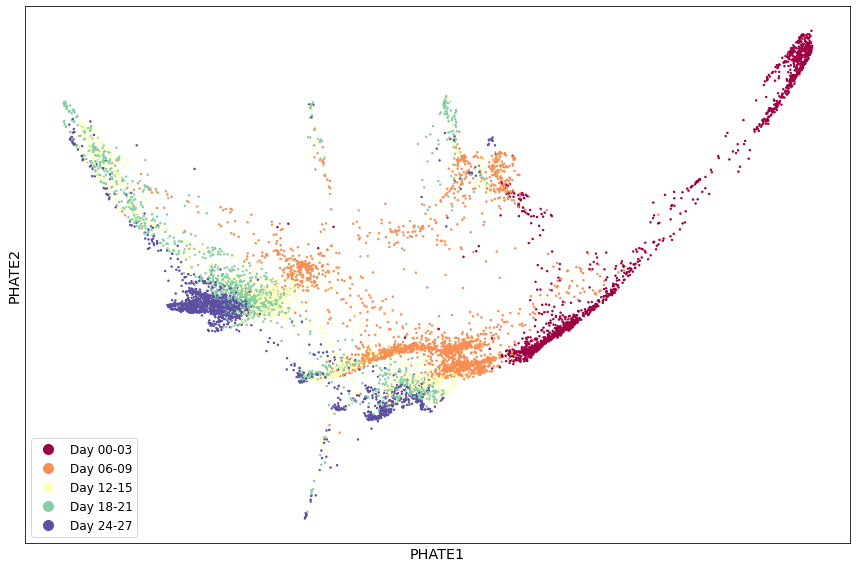

In [9]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

# 4. Clustering

## 4.1 Introduction to clustering

#### What is clustering?

The goal of clustering is to identify a partition of the data such that all of the observations within each partition (called a cluster) are more similar to each other than they are to those in other clusters. Many clustering algorithms exist, and they each have their own quirks (just like visualization algorithms). `sklearn` has implementations for some of the most popular ones and their [User Guide on Clustering](https://scikit-learn.org/stable/modules/clustering.html) is a good resource to understand general clustering approaches.

Here, we run a variety of clustering algorithms. We'll use `tasklogger` to measure how long each one takes.

In [0]:
data_pca = scprep.reduce.pca(data, n_components=50, method='dense')

In [11]:
phenograph_clusters, _, _ = phenograph.cluster(data_pca)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 5.68619704246521 seconds
Jaccard graph constructed in 3.9744904041290283 seconds
Wrote graph to binary file in 1.1656551361083984 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.84847
After 5 runs, maximum modularity is Q = 0.849802
Louvain completed 25 runs in 4.706050634384155 seconds
PhenoGraph complete in 15.571938753128052 seconds


In [12]:
with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters=20).fit_predict(data_pca)

Calculating KMeans...
Calculated KMeans in 2.74 seconds.


In [0]:
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()

In [14]:
with tasklogger.log_task("Louvain"):
    partition = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                       weights="weight", resolution_parameter=1)
    louvain_clusters = np.array(partition.membership)

Calculating Louvain...
Calculated Louvain in 1.51 seconds.


In [15]:
with tasklogger.log_task("Spectral clustering"):
    spec_op = sklearn.cluster.SpectralClustering(n_clusters=20, affinity='precomputed')
    spectral_clusters = spec_op.fit_predict(G.K)

Calculating Spectral clustering...
Calculated Spectral clustering in 21.63 seconds.


## 4.2 Clustering single cell data

#### Clustering methods for single cell RNA-seq

In the previous exercise, we compared three popular algorithms for clustering: KMeans, Spectral Clustering, and Louvain.

#### Reordering clusters by PHATE coordinates

By default, cluster numbers are meaningless. This makes it difficult to compare clusterings, because cluster "0" can refer to entirely different cells between runs of the same algorithm.

To enforce some consistency, we are going to reorder the clusters so that cluster "0" is always on the far right of the PHATE plot, and the highest-numbered cluster is always on the far left.

In [0]:
clusterings = {'Phenograph':phenograph_clusters,
               'Louvain':louvain_clusters, 
               'KMeans':kmeans_clusters, 
               'Spectral':spectral_clusters}

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_phate.iloc[:,0])
    clusterings[alg] = cl_nu

#### Plotting clusters with PHATE

Above, we colored our scatter plots using expression of a marker gene. However, we can use any information with one value per cell to color the plot. Here, we're using the cluster identity.

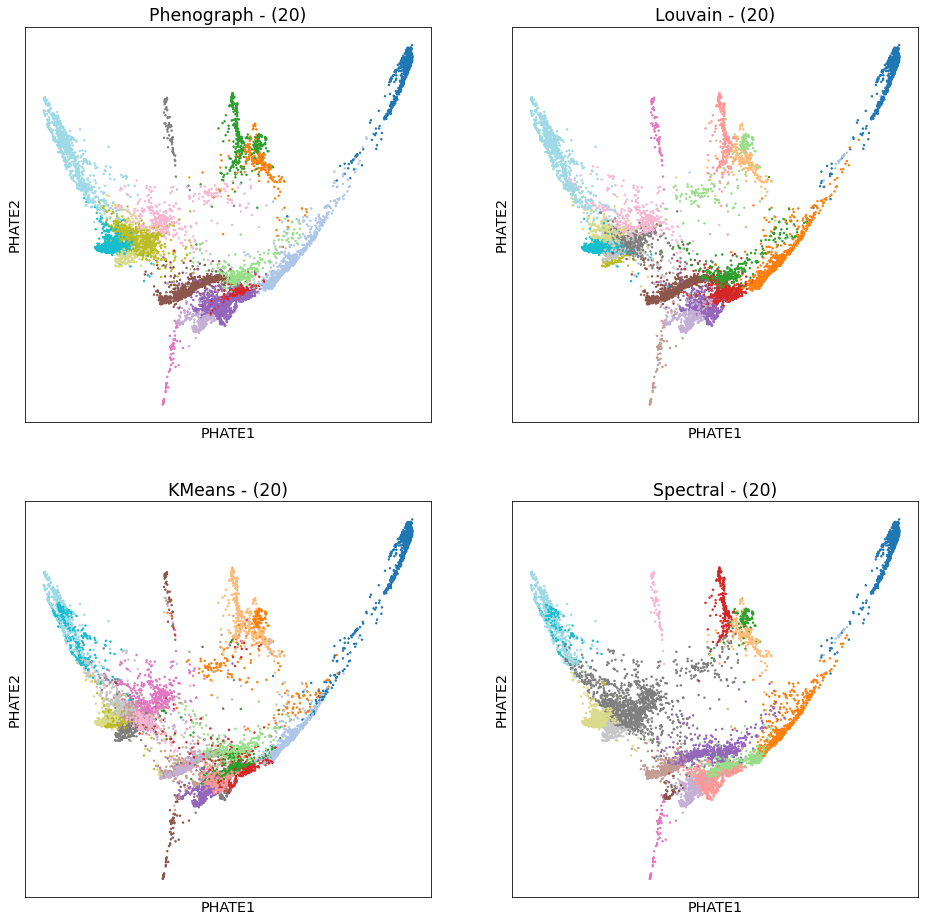

In [17]:
fig, axes = plt.subplots(2,2, figsize=(16,16))

for ax, algorithm in zip(axes.flatten(), clusterings):
    scprep.plot.scatter2d(data_phate, c=clusterings[algorithm], cmap=plt.cm.tab20,
                          title='{} - ({})'.format(algorithm, len(np.unique(clusterings[alg]))), 
                          ticks=False, label_prefix="PHATE", legend=False, discrete=True,
                          ax=ax)

We can also plot each cluster individually to see where they are on the PHATE plot

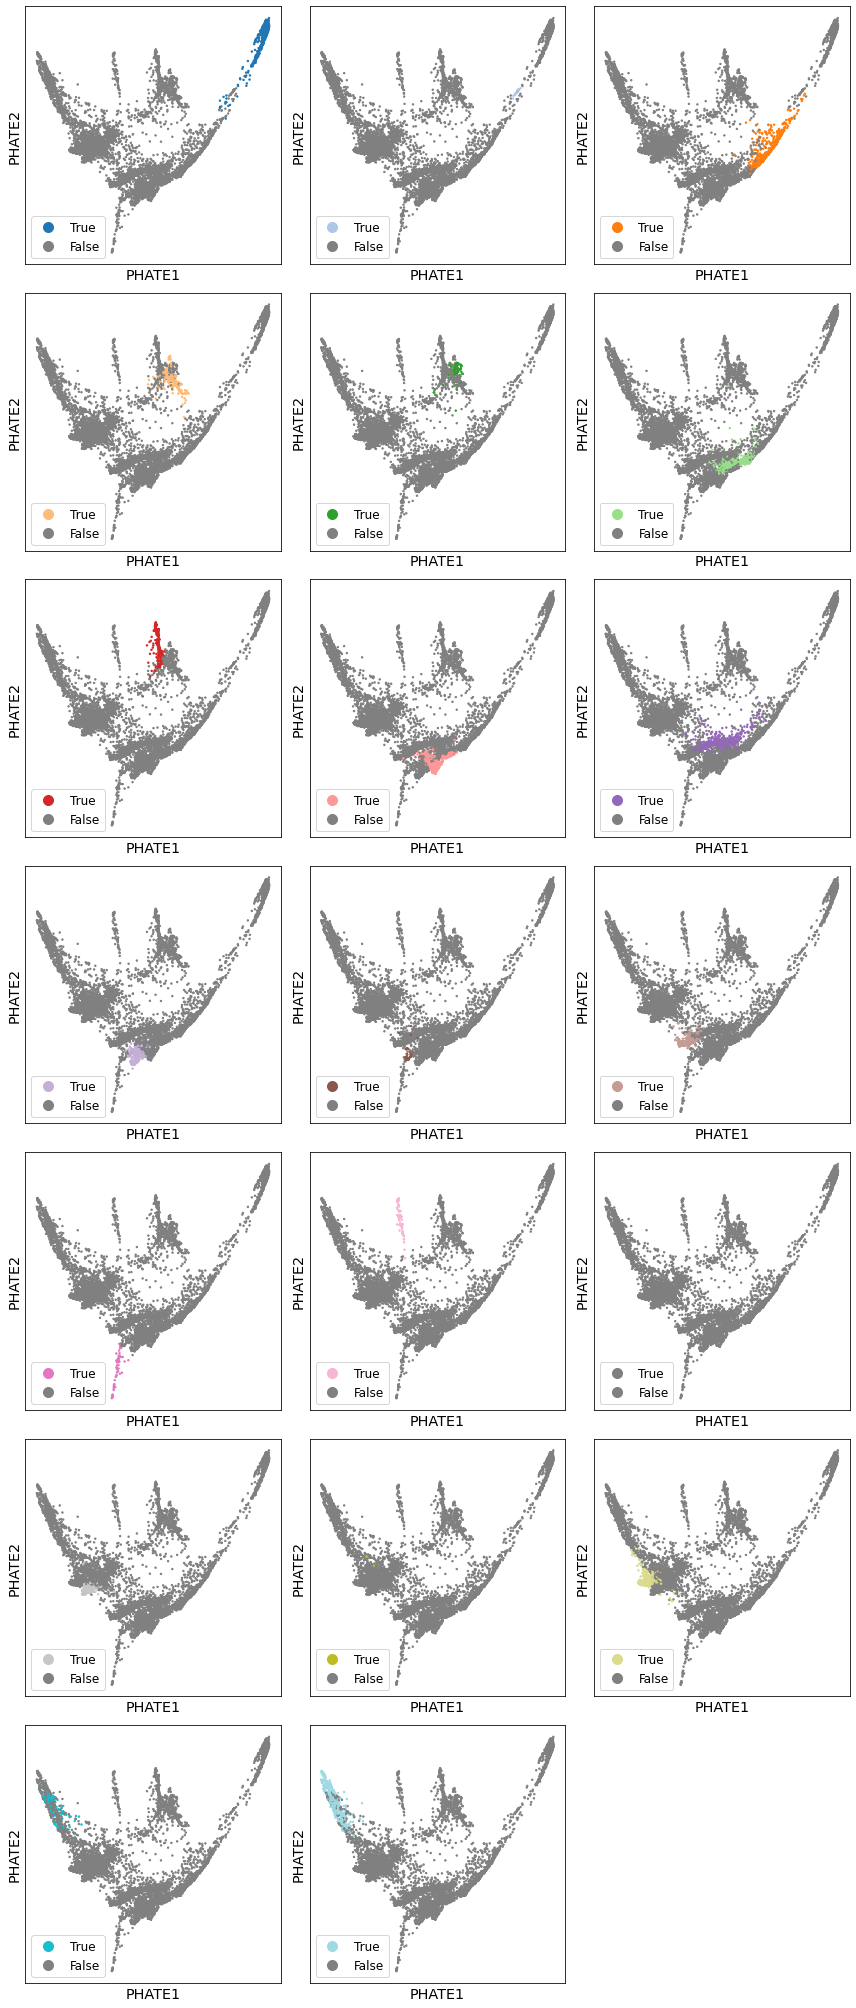

In [18]:
n_rows = 7
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*4))
axes = axes.flatten()
clusters = clusterings['Spectral']
cluster_ids = np.unique(clusters)
for i in range(len(axes)):
    ax = axes[i]
    try:
        curr_cluster = cluster_ids[i]
        # Returns array([False, True,...,False]) indicating if each cell is in the
        # current cluster
        curr_mask = clusters == curr_cluster  
        scprep.plot.scatter2d(data_phate, c=curr_mask,
                              cmap={True: plt.cm.tab20.colors[i], False: 'grey'},
                              ticks=False, label_prefix='PHATE', ax=ax)
    except IndexError:
        # we have more axes than clusters
        ax.axis('off')


fig.tight_layout()

### How quantitatively similar are the clustering algorithms?

We can use a metric, called the adjusted rand score, to quantify how similar any given clustering results are to each other. This is a similarity metric, so two identical clusterings will produce a score of `1.0`. If every point is randomly assigned to different clusters, then the adjusted rand score will be close to `0.0`. You can learn more about this metric in the `sklearn` user guide: https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score.

#### Grouping all of the cluster vectors into a single array

Reading the following code, can you guess what shape `all_clusterings` will be at the end of the code block? 

In [0]:
all_clusterings = []
all_algorithms = list(clusterings.keys())
for algo in all_algorithms:
    all_clusterings.append(clusterings[algo])    
all_clusterings = np.vstack(all_clusterings)

Here, we're using `pdist` with a custom distance metric. Note, `sklearn.metrics.adjusted_rand_score` is actually a similarity metric, not a distance metric. So this code is not good practice and qualifies as a hack. That being said, it works.

In [0]:
from scipy.spatial.distance import pdist, squareform
cluster_similarities = squareform(pdist(all_clusterings, metric=sklearn.metrics.adjusted_rand_score))
# squareform assumes diagonals will be 0, but they're actually 1 because this is a similarity metric
# so we need to add 1's on the diagonal with np.eye()
cluster_similarities = cluster_similarities + np.eye(4)

#### Plot a clustermap of distances

With your partner, interpret this heatmap. Which cluster results are the most similar or different?

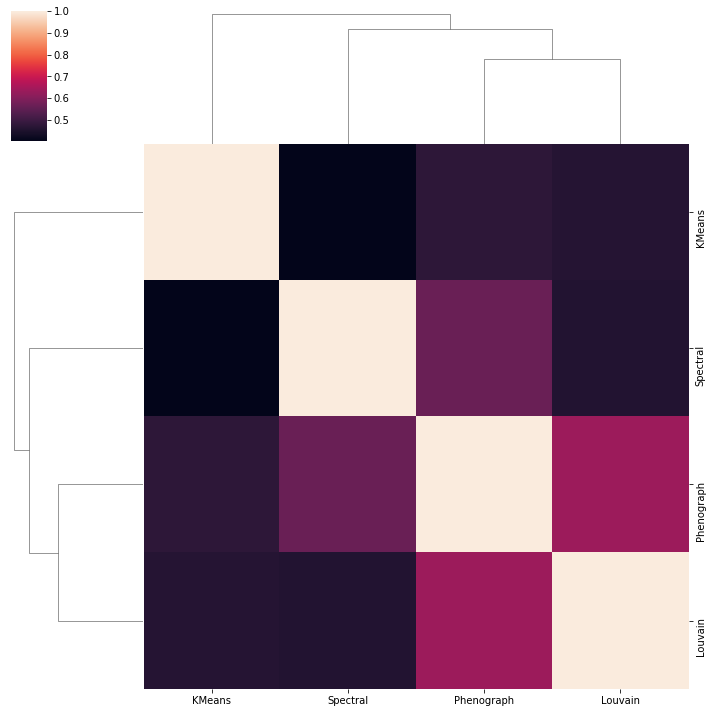

In [21]:
sns.clustermap(cluster_similarities, xticklabels=all_algorithms, yticklabels=all_algorithms)



## Characterizing clusters

Now, we want to characterize gene expression in each cluster to identify the cell type of that cluster. Cell type is easy to grasp intuitively, but hard to formalize. Generally, we want a cell that expresses a set of genes differently than the rest of the cells in the dataset. As part of writing the PHATE paper, we characterized all the cell types in this time course, and made the following fate map.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/EB_lineage_map.png" style="height: 40rem;"/>

>Lineage tree of the EB system determined from the PHATE analysis showing embryonic stem cells (ESC), the primitive streak (PS), mesoderm  (ME), endoderm (EN), neuroectoderm (NE), neural crest (NC), neural progenitors (NP), lateral plate ME (LP ME), hemangioblast (H), cardiac (C), epicardial precursors (EP), smooth muscle precursors (SMP), cardiac precursors (CP), and neuronal subtypes (NS).

In groups, you need to examine the expression of these sets of genes and figure out which cell type matches your cluster.

### Selecting a set of clusters

As a group, decide on a clustering result to use for this next exercise. Each member of the group will then pick a cluster to manually annotate based on known markers.

In [0]:
# ==============
# choose your favorite clustering method from 'Phenograph', 'Louvain', 'KMeans', 'Spectral'
clusters = clusterings[ 'Louvain' ]
# ==============

### Jitterplot

The following plot is called a [jitterplot](https://scprep.readthedocs.io/en/stable/examples/jitter.html). This plot is similar to a [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) or a [swarmplot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html), but is computationally cheaper. The goal of this plot is to examine the distribution of values associated with each cell in a set of clusters.

Each point is a cell and the x-axis represents the cluster assignment of that cell. There's a little bit of noise added to the x-position of the cell (that's the jitter). The y-axis represents expression of a given gene.

You can change which gene is plotted by changing the `curr_gene` variable. All of the genes in the above plot will work.

FYI: when a gene is listed as `ZIC2/5`, this actually represents two genes: `ZIC2` and `ZIC5`.

Try running with and without MAGIC and determine which is more helpful for identifying clusters.

#### Raw data

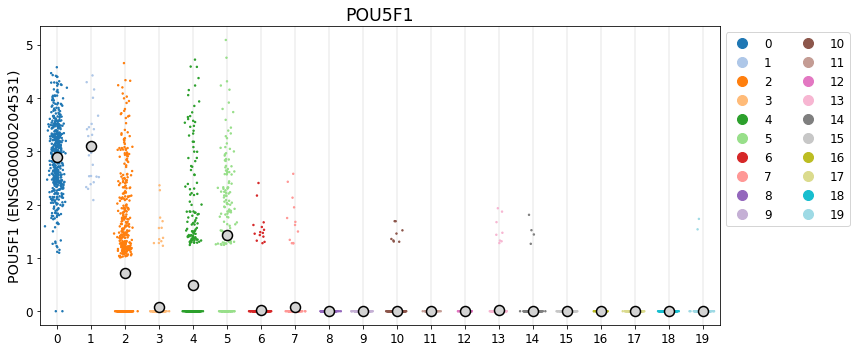

In [23]:
curr_gene = 'POU5F1'
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

#### MAGIC

Let's plot the same thing with denoised data from MAGIC.

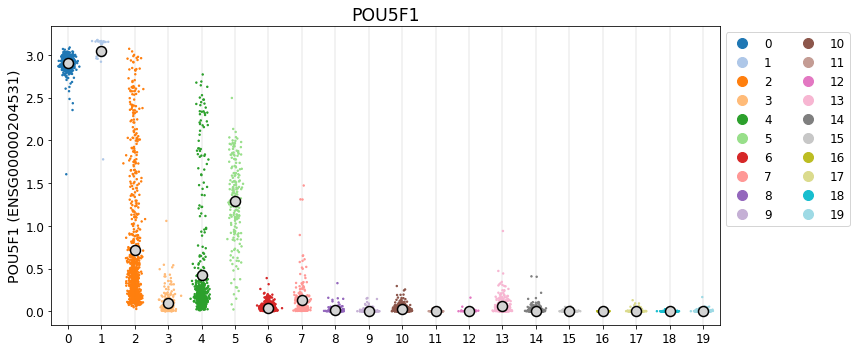

In [24]:
curr_gene = 'POU5F1'
curr_expression = scprep.select.select_cols(data_magic, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

#### Examining expression on PHATE

The other tool you should use for examining clusters is the PHATE plots we used above. You can change the `genes_for_plotting` list, as long as you keep it restricted to three genes.

Again change `data` to `data_magic` and determine if this makes annotating clusters easier.

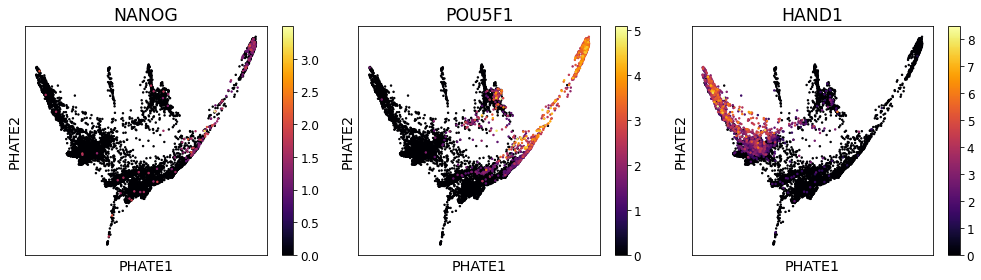

In [25]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
genes_for_plotting = ['NANOG', 'POU5F1', 'HAND1']

for curr_gene, ax in zip(genes_for_plotting, axes.flatten()):
    
    expression = scprep.select.select_cols(data, exact_word=curr_gene)
    
    sort_index = expression.sort_values().index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='PHATE', ax=ax)

fig.tight_layout()

### Discussion

Now, in your groups, choose a cell type from the above lineage map. Please complete the following tasks:

1. Identify which cluster corresponds to your cell type of interest. 
2. Create a PHATE plot that highlights your cells of interest in some way (i.e. shows them in another color). Does this plot make sense with the position of your cell type in the developmental lineage? What information can you learn about your cell type from the PHATE plot?
3. Open coding exercise: Create another plot that shows something interesting about your cell type. This plot should answer a biological question, for example:

      a. Is the expression of marker genes heterogeneous within your cluster?
      
      b. Are your cells present at multiple time points?
      
      c. What other genes are uniquely expressed in your cell type?

# Differential expression

In the above exercise, we manually inspected known marker genes to annotate clusters. Here, we're going to simply identify the genes that change the most between two groups. As discussed in lecture, there are several ways to calculate differential expression. We are going to focus on the mean-difference and the rank-sum statistic.

You can easily calculate basic differential expression statistics using `scprep.stats.differential_expression` and `scprep.stats.differential_expression_by_cluster`. More details about these methods can be found in the [documentation](https://scprep.readthedocs.io/en/stable/reference.html#scprep.stats.differential_expression).



In [0]:
data_sparse = scprep.utils.SparseDataFrame(data)

In [27]:
curr_cluster = 0
with tasklogger.log_task("t-test"):
    ttest_results = scprep.stats.differential_expression(data_sparse[clusters == curr_cluster], 
                                                         data_sparse[clusters != curr_cluster], 
                                                         measure='ttest')

Calculating t-test...
Calculated t-test in 37.40 seconds.


In [0]:
top_genes = ttest_results['ttest'].abs().sort_values(ascending=False)[:50]

#### Print the 20 most differentially expressed genes

In [29]:
top_genes.head(n=20)

POU5F1 (ENSG00000204531)    94.453385
MDK (ENSG00000110492)       82.468594
CD24 (ENSG00000272398)      80.330299
ZNF503 (ENSG00000165655)    80.140075
VIM (ENSG00000026025)       78.167781
MGST1 (ENSG00000008394)     76.595910
TERF1 (ENSG00000147601)     74.660950
MALAT1 (ENSG00000251562)    72.727745
COL3A1 (ENSG00000168542)    64.366257
TDGF1 (ENSG00000241186)     63.062103
SNRPN (ENSG00000128739)     60.853579
SET (ENSG00000119335)       57.290564
TMSB4X (ENSG00000205542)    56.553230
CRABP2 (ENSG00000143320)    56.304750
MEIS2 (ENSG00000134138)     55.474529
LUM (ENSG00000139329)       54.756292
COX7C (ENSG00000127184)     53.828123
HOXB2 (ENSG00000173917)     53.546160
RPL6 (ENSG00000089009)      52.768355
RPS26 (ENSG00000197728)     52.574910
Name: ttest, dtype: float64

### Plotting a histogram of gene expression in your cluster and in all other clusters

Hints:

1. Use `scprep.plot.histogram` (https://scprep.readthedocs.io/en/dev/reference.html#scprep.plot.histogram). 
 * Note, you can pass an list of expression values to get them plotted on the same axis.
 * Try using `log='y'` to get a log-scale y-axis.  When we plot on log-scale we are not changing the values themselves, but rather scaling the y-axis.  This is useful because the dynamic range of the values can be very large.
 * Use `title=` to set the title.
 * The blue / grey histogram is the first group in the list, orange is the rest.
2. Use the code from the `scprep.stats.differential_expression` to select the rows of a DataFrame in your cluster and not in your cluster.
3. The gene names are stored in `top_genes.index`. How would you select the 0th item from this index?

In [0]:
# ======
# Write code to create a histogram here
curr_gene = 
expression_in_cluster = 
expression_not_in_cluster = 


scprep.plot.histogram(

# ======

### Creating a heatmap of differentially expressed genes

#### Creating a heatmap using `sns.clustermap`

First, we'll do the simplest thing and create a simple `clustermap`. 

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


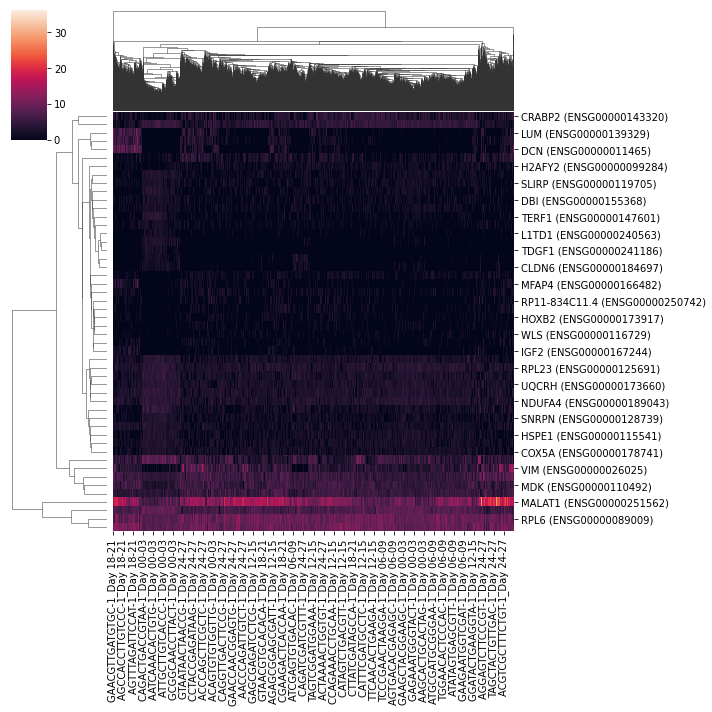

In [30]:
sns.clustermap(data_sparse[top_genes.index].T)

#### Why does this look bad?

Notice that the ranges of expression for each gene is very different. In order to get a pretty plot, we'll need to normalize the data first.

### Z-score standardizing the data

We can easily z-score standardize the data using `sklearn.preprocessing.StandardScalar`. This will mean-center each columns of the `de_data` and set the standard deviation of each column to 1.

In [0]:
de_data = data_sparse[top_genes.index]
de_data_zscore = sklearn.preprocessing.StandardScaler().fit_transform(de_data)

#### Generating `col_colors`

We can add colors for each column in the clustermap using a `col_colors` variable that has one RBGA or hex color per column of the data.

In [0]:
col_colors = plt.cm.tab20(clusters)

#### Calculating color limits so the `cmap` is centered at 0

In [0]:
lim = np.max(np.abs(de_data_zscore))

#### Generating the pretty clustermap

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


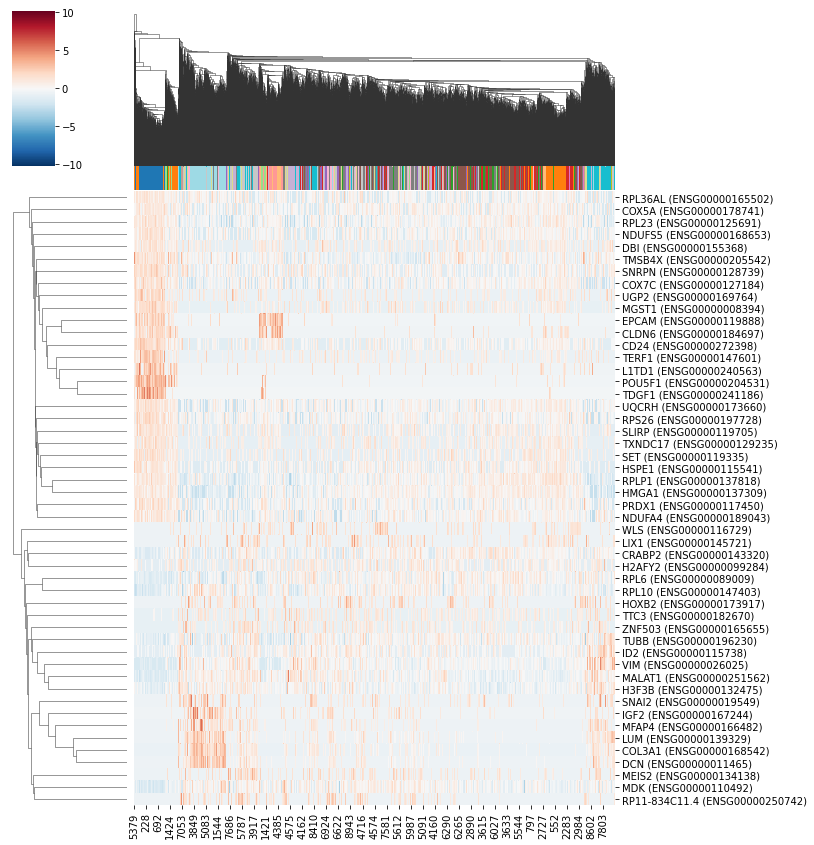

In [34]:
cg = sns.clustermap(de_data_zscore.T, col_colors=col_colors, cmap='RdBu_r', 
                    vmin=-lim, vmax=lim, yticklabels=de_data.columns.values)

cg.ax_heatmap.figure.set_size_inches(12,12)

In [35]:
de_data_zscore.T.shape

(50, 9750)

### Discussion

Using the clusters that you annotated in the previous exercise, perform the differential expression analysis for that cluster and generate the above heatmap and histogram. 

1. What do you notice about how uniformly each gene is expressed in each cluster?
2. How well does the clustermap separate your cluster from other clusters based on each individual gene?
3. Try plotting heatmaps for the 500-550th most DE genes or the 7000-7050 most DE genes. Try the 50 least differentially expressed genes. What do you notice about these plots compared to the ones for the most DE genes?



